## Code_Changes_Lines
This is the reference implementation for [Code_Changes_Lines](https://github.com/chaoss/wg-evolution/blob/master/metrics/Code_Changes_Lines.md),
a metric specified by the
[Evolution Working Group](https://github.com/chaoss/wg-evolution) of the
[CHAOSS project](https://chaoss.community).

Have a look at [README.md](../README.md) to find out how to run this notebook (and others in this directory) as well as to get a better understanding of the purpose of the implementations.

The implementation is described in two parts (see below):

* Class for computing Code_Changes_Lines
* An explanatory analysis of the class' functionality

Some more auxiliary information in this notebook:

* Examples of the use of the implementation

As discussed in the [README](../README.md) file, the scripts required to analyze the data fetched by Perceval are located in the `scripts` package. Due to python's import system, to import modules from a package which is not in the current directory, we have to either add the package to `PYTHONPATH` or simply append a `../..` to `sys.path`, so that `scripts` can be successfully imported. 

In [18]:
from datetime import datetime
import matplotlib.pyplot as plt

import sys
sys.path.append('../..')

from implementations.scripts import utils, conditions
from implementations.scripts.commit_git import CommitGit

In [19]:
class CodeChangesLinesGit(CommitGit):
    """
    Class for Code_Changes_Lines for Git repositories
    with a non-pandas approach.
    """

    def _flatten(self, item):
        """
        Flatten a raw commit fetched by Perceval into a flat dictionary.

        A list with a single flat directory will be returned.
        That dictionary will have the elements we need for computing metrics.
        The list may be empty, if for some reason the commit should not
        be considered.

        :param item: raw item fetched by Perceval (dictionary)
        :returns:    list of a single flat dictionary
        """

        creation_date = utils.str_to_date(item['data']['AuthorDate'])
        if self.since and (self.since > creation_date):
            return []

        if self.until and (self.until < creation_date):
            return []

        code_files = [file['file'] for file in item['data']['files'] if
                      all(condition.check(file['file'])
                          for condition in self.is_code)]

        if len(code_files) > 0:
            flat = {
                'repo': item['origin'],
                'hash': item['data']['commit'],
                'author': item['data']['Author'],
                'category': "commit",
                'created_date': creation_date,
                'committer': item['data']['Commit'],
                'commit_date': utils.str_to_date(item['data']['CommitDate']),
                'files_no': len(item['data']['files']),
                'refs': item['data']['refs'],
                'parents': item['data']['parents'],
                'files': item['data']['files'],
                'message': item['data']['message']
            }

            # actions
            actions = 0
            for file in item['data']['files']:
                if 'action' in file:
                    actions += 1
            flat['files_action'] = actions

            # Merge commit check
            if 'Merge' in item['data']:
                flat['merge'] = True
            else:
                flat['merge'] = False

            # modifications
            modified_lines = 0
            for file in item['data']['files']:
                if 'added' and 'removed' in file:
                    try:
                        modified_lines += int(file['added']) + int(file['removed'])

                    except ValueError:
                        # in case of compressed files,
                        # additions and deletions are "-"
                        pass

            flat['modifications'] = modified_lines

            return [flat]
        else:
            return []

    def compute(self):
        """
        Compute the number of lines modified in the data fetched
        by Perceval.

        It computes the sum of the 'modifications' key
        in the dictionary.

        :returns modifications_count: The total number of
            lines modified (int)
        """

        modifications_count = 0
        for item in self.items:
            modifications_count += item['modifications']

        return modifications_count

## Performing the Analysis
Using the above class, we can perform several kinds of analysis on the JSON data file, fetched by Perceval. 
For starters, we can perform a simple calculation of the number of modified lines (additions plus deletions) in the file. To make things simple, we will use the `Naive` implementation for deciding whether a given commit affects the source code or not. Again, the naive implementation assumes that all files are part of the source code, and hence, all commits are considered to affect it. The `Naive` implementation is the default option. 

### Counting the total number of modified lines 
We first read the JSON file containing Perceval data using the `read_json_file` utility function. 

In [20]:
items = utils.read_json_file('../git-commits.json')

Let's use the `compute` method to count the total number of lines modified after instantiating the above class.

Notice that here, we are redefining the `_flatten` method of the `CommitGit` class, the parent of the `CodeChangesLinesGit` class. The reason for doing this is to add a `modifications` key to the dictionary. This makes it easier to compute this metric.

First, we will do the computation without passing any since and until dates. Next, we can pass in the start and end dates as a tuple. The format would be `%Y-%m-%d`.

In [21]:
changes = CodeChangesLinesGit(items)
print("The total number of modified lines "
      "in the file is {}.".format(changes.compute()))

date_since = datetime.strptime("2018-01-01", "%Y-%m-%d")
date_until = datetime.strptime("2018-07-01", "%Y-%m-%d")    

changes_dated = CodeChangesLinesGit(items,
                        date_range=(date_since, date_until))
                        
print("The total number of lines modified between "
      "2018-01-01 and 2018-07-01 is {}.".format(changes_dated.compute()))

The total number of modified lines in the file is 563670.
The total number of lines modified between 2018-01-01 and 2018-07-01 is 192972.


### Counting the total number of lines modified by commits excluding merge commits
Moving on, lets make use of the `EmptyExclude` and `MergeExclude` classes to filter out empty and merge commits respectively. These classes are sub-classes of the `CommitGit` class in the `conditions` module. They provide two methods: `check()` and `set_commits`.

The `set_commits` method selects commits which satisfy a given condition (like excluding empty commits, for example) and stores the hashes of those commits in the set `included`, an instance variable of all `Commit` classes. 

The `check()` method checks each commit in the dictionary created from Perceval data and removes those commits which correspond to commits not in `included`. 

In [22]:
changes_non_merge = CodeChangesLinesGit(items, 
                                  (date_since, date_until),
                                  conds=[conditions.MergeExclude()])
print("The total number of lines modified by non-merge commits between"
      " 2018-01-01 and 2018-07-01 is {}.".format(changes_non_merge.compute()))

The total number of lines modified by non-merge commits between 2018-01-01 and 2018-07-01 is 94047.


### Counting line modifications by commits only made on the master branch
Another option one has while using this class for analyzing git commit data is to include only those commits for analysis which are on the master branch. To do this, we pass in an object of the `MasterInclude` class as a list to the `conds` parameter while instantiating the `CodeChangesLinesGit` class.

We compute the number of commits created on the master branch after `2018-01-01`, which we stored in the `datetime` object, `date_since`. 

In [23]:
changes_only_master = CodeChangesLinesGit(items,
                                    date_range=(date_since, None),
                                    conds=[conditions.MasterInclude()])

print("The total number of lines modified (additions, deletions) by commits made on the master branch "
      "after 2018-01-01 is {}.".format(changes_only_master.compute()))

The total number of lines modified (additions, deletions) by commits made on the master branch after 2018-01-01 is 215191.


Lets do one last thing: the same thing we did in the cell above, but without including empty commits. In this case, we would also need to pass a `conditions.ExcludeEmpty` object to `conds`. 

Also, lets exclude those commits which work solely on `markdown` files. We use the `PostfixExclude` class, a sub-class of `Code` for this.

In [24]:
changes_non_empty_master = CodeChangesLinesGit(items,
                                          is_code=[conditions.PostfixExclude(postfixes=['.md'])],
                                          conds=[conditions.MasterInclude(), conditions.EmptyExclude()])

print("The total number of lines modified by non-empty commits made on the master branch is: {}".format(changes_non_empty_master.compute()))

The total number of lines modified by non-empty commits made on the master branch is: 9226


### Counting line modifications by commits with a specific tag in their message
If the project has a guideline for the writting of the message of commits, we have the possibility to classify these commits. For example, if the code changes in a commit corrects a bug, the message of the commit can be `"[FIX] add path into sys.path to include correctly scripts for metrics"`.
With the `[FIX]` tag, we can count number of lines modified for the bug fixes.

In `git-commits.json`, some commits have these next tags into their message : `[api]` and `[backend]`.

In [25]:
tags = ["[api]", "[backend]"]
result = []
for tag in tags:
    code_changes_lines = CodeChangesLinesGit(items, conds=[conditions.CommitByTag(tag)]).compute()
    result.append(code_changes_lines)
    print("Code_Changes, only for the commits that contain {} into their message: {}".format(
        tag,
        code_changes_lines))


Code_Changes, only for the commits that contain [api] into their message: 11071
Code_Changes, only for the commits that contain [backend] into their message: 3245


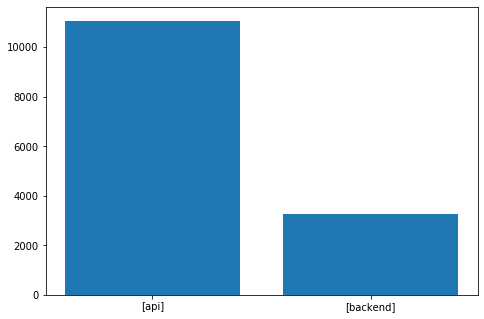

In [30]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(tags, result)
plt.show()